## Code for CAP2018 Shared task English level prediction

This code can be used to make a prediction based on the approach described in the slides.
In the final submission this code has been run ten time with varying splits for step 1 - step 2 and the dense results were averaged before thresholding 

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

import xgboost as xgb
from sklearn.linear_model import SGDClassifier
import scipy 

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [2]:
# load data
df = pd.read_csv('train_cap2018.csv')
data_test = pd.read_csv('test_cap2018.csv')
text_and_label,text_and_label_val = train_test_split(df[['level1','fulltext']],test_size = .5)

## Step 1 predictor : Sparse classifier based on text data

In [3]:
# parameters for grid search at step 1
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': ( 1.,),
    'vect__min_df': (1,),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 2),),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001,),
    'clf__penalty': ('l2',),
    'clf__max_iter': (50, 200),
    # 'clf__max_iter': (200,),
    #'clf__max_iter': (400, 800),
}

In [4]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(text_and_label.fulltext.tolist(),text_and_label.level1)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   33.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   33.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__ngram_range': ((1, 2),), 'clf__max_iter': (50, 200), 'vect__max_df': (1.0,), 'vect__min_df': (1,), 'clf__penalty': ('l2',), 'clf__alpha': (1e-05,)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [5]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__alpha,param_clf__max_iter,param_clf__penalty,param_vect__max_df,param_vect__min_df,param_vect__ngram_range,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,10.797516,1.833223,0.945002,1.0,1e-05,50,l2,1,1,"(1, 2)",...,0.947727,1.0,0.941344,1.0,0.945934,1.0,0.049615,0.027626,0.002688,0.0
1,15.240000,1.114954,0.945368,1.0,1e-05,200,l2,1,1,"(1, 2)",...,0.948605,1.0,0.941784,1.0,0.945714,1.0,2.299040,0.172507,0.002796,0.0


In [6]:
# select best estimators (for displaying )
sgd_best = grid_search.best_estimator_.steps[-1][1]
counter_vect_best = grid_search.best_estimator_.steps[0][1]

(40,)
(40,)


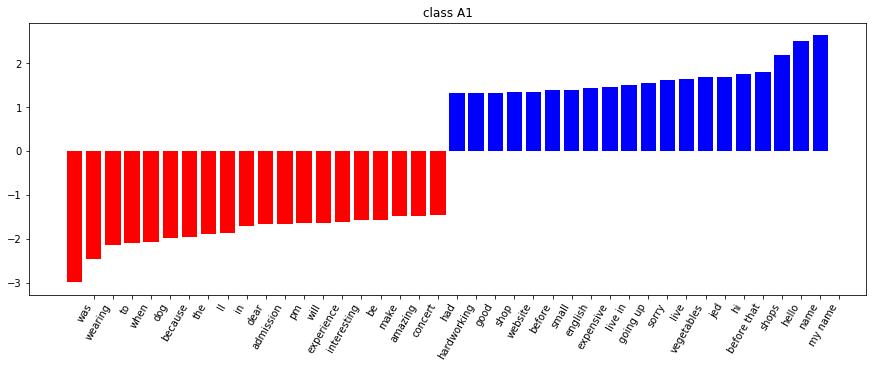

(40,)
(40,)


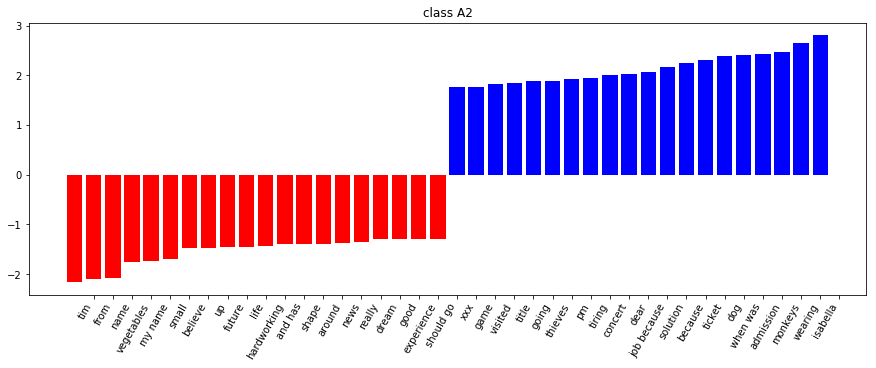

(40,)
(40,)


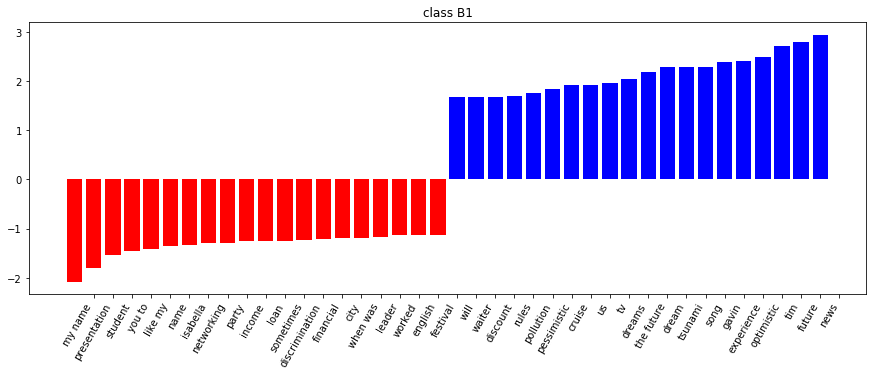

(40,)
(40,)


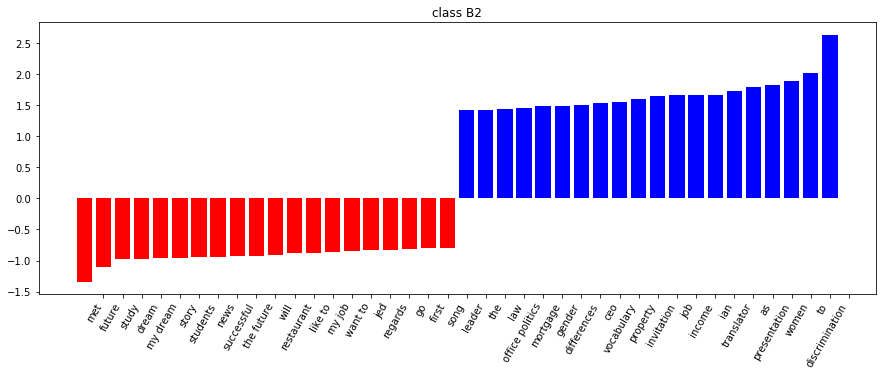

(40,)
(40,)


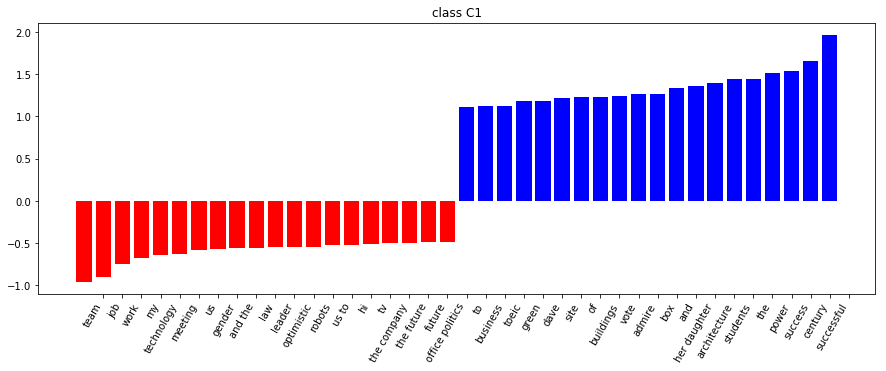

(40,)
(40,)


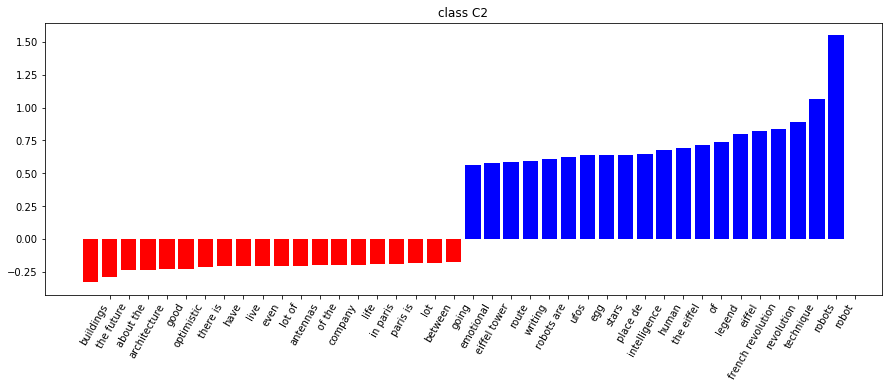

In [7]:
def plot_coefficients(classifier, feature_names, top_features=20):
    classes = ['A1','A2','B1','B2','C1','C2']
    for i in range(classifier.coef_.shape[0]):
        coef = classifier.coef_[i,:]
        top_positive_coefficients = np.argsort(coef)[-top_features:]
        top_negative_coefficients = np.argsort(coef)[:top_features]
        top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
        # create plot
        plt.figure(figsize=(15, 5))
        colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
        feature_names_chosen = [feature_names[j] for j in top_coefficients]
        coef_chosen = np.array([coef[j] for j in top_coefficients])
        print(np.arange(2 * top_features).shape)
        print(coef_chosen.shape)
        plt.bar(np.arange(2 * top_features), coef_chosen, color=colors)
        
       
        plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names_chosen, rotation=60, ha='right')
        plt.title('class '+str(classes[i]))
        plt.show()
        
        
# display top vocabulary    
plot_coefficients(sgd_best,counter_vect_best.get_feature_names())

In [8]:

def our_loss(y,y_pred):
    preds_thresh = np.maximum(np.minimum(np.round(y_pred)-1,5),0)
    score_mat = np.array([[0,1,2,3,4,6],[1,0,1,4,5,8],[3,2,0,3,5,8],[10,7,5,0,2,7],[20,16,2,4,0,8],[44,38,32,19,13,0]])
    score = [score_mat[int(i),int(j)] for i,j in zip(y-1,np.round(preds_thresh))]
    return -np.mean(score) # returns negative loss for sklearn grid search compatibility

In [9]:
pred = grid_search.best_estimator_.predict(df.loc[text_and_label_val.index].fulltext.tolist())

In [10]:
df_train = df.loc[text_and_label.index]
df_val = df.loc[text_and_label_val.index]

In [11]:
# score obtained with step 1 only on second half
predn = pd.get_dummies(pred)
pred_ordinal = predn.dot(np.asarray(list(range(1,7))))

Y_val = pd.get_dummies(df_val.level1)
Y_val_ordinal = Y_val.dot(np.asarray(list(range(1,7))))
our_loss(Y_val_ordinal,pred_ordinal)

-0.16257781032588794

## Step 2 : Dense predictor based on a fusion of step 1 and provided features

In [12]:
df_train_vocab_pred = pd.DataFrame(grid_search.best_estimator_.decision_function(df_train.fulltext),index = df_train.index)
df_val_vocab_pred = pd.DataFrame(grid_search.best_estimator_.decision_function(df_val.fulltext),index = df_val.index)

# compute sparse features decision function distance on train
df_train_vocab_pred.columns = ['vocab_decision_function_'+str(i) for i in df_train_vocab_pred.columns]
df_val_vocab_pred.columns = ['vocab_decision_function_'+str(i) for i in df_val_vocab_pred.columns]
df_train = df_train.join(df_train_vocab_pred)
df_val = df_val.join(df_val_vocab_pred)

# on test :
df_test_vocab_pred = pd.DataFrame(grid_search.best_estimator_.decision_function(data_test.fulltext),index = data_test.index)
df_test_vocab_pred.columns = ['vocab_decision_function_'+str(i) for i in df_test_vocab_pred.columns]
data_test = data_test.join(df_test_vocab_pred)

In [13]:
Y_train = pd.get_dummies(df_train.level1)
Y_train_ordinal = Y_train.dot(np.asarray(list(range(1,7))))
X_train = df_train.drop(['fulltext','MATTR','MSTTR','level1'],axis = 1) # drop text and incomplete columns

Y_val = pd.get_dummies(df_val.level1)
Y_val_ordinal = Y_val.dot(np.asarray(list(range(1,7))))
X_val = df_val.drop(['fulltext','MATTR','MSTTR','level1'],axis = 1)

In [14]:
params_xgb = {'max_depth': [4,6,8,10], 'learning_rate': [0.1],'colsample_bytree':[.9],'n_estimators':[100]} 
# minimal c.v. parameters -> can be made bigger

custom_score = make_scorer(our_loss) # stop c.v. on best score according to target loss

clf_xgb = xgb.XGBRegressor()
grid = GridSearchCV(clf_xgb, params_xgb,scoring = custom_score,cv = 5,n_jobs = -1)

In [15]:
decision_function_features = ['vocab_decision_function_0','vocab_decision_function_1',
                    'vocab_decision_function_2','vocab_decision_function_3',
                    'vocab_decision_function_4','vocab_decision_function_5']

In [16]:
info_step_2 = grid.fit(X_val, Y_val_ordinal) # use all features
#grid.fit(X_val[decision_function_features], Y_val_ordinal) # use sparse only

In [17]:
# cv results
pd.DataFrame(grid.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,params,rank_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,6.279143,0.032458,-0.097034,-0.049707,0.9,0.1,4,100,"{u'n_estimators': 100, u'learning_rate': 0.1, ...",4,...,-0.124130,-0.046595,-0.071036,-0.052270,-0.098499,-0.050439,0.568136,0.004803,0.018528,0.001923
1,11.397308,0.047567,-0.085683,-0.015562,0.9,0.1,6,100,"{u'n_estimators': 100, u'learning_rate': 0.1, ...",3,...,-0.112047,-0.016203,-0.061150,-0.017393,-0.079092,-0.015471,0.078077,0.012000,0.017632,0.001314
2,15.380982,0.053252,-0.084218,-0.000165,0.9,0.1,8,100,"{u'n_estimators': 100, u'learning_rate': 0.1, ...",2,...,-0.103991,-0.000000,-0.058587,-0.000183,-0.090443,-0.000458,0.373157,0.013471,0.015024,0.000168
3,16.743849,0.048529,-0.083999,0.000000,0.9,0.1,10,100,"{u'n_estimators': 100, u'learning_rate': 0.1, ...",1,...,-0.097400,-0.000000,-0.057122,-0.000000,-0.092640,-0.000000,1.786634,0.006256,0.014803,0.000000


In [18]:
# top 10 features
X_val.columns[np.argsort(grid.best_estimator_.feature_importances_)[::-1]][:10]

Index([u'sentences', u'words', u'text', u'vocab_decision_function_1',
       u'vocab_decision_function_3', u'vocab_decision_function_2',
       u'vocab_decision_function_4', u'vocab_decision_function_0',
       u'letters.all', u'avg.sentc.length'],
      dtype='object')

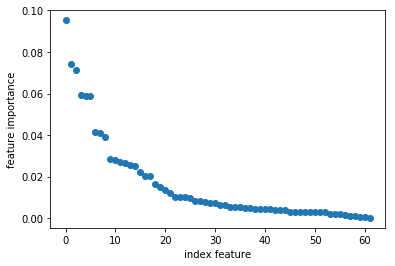

In [19]:
plt.plot(np.sort(grid.best_estimator_.feature_importances_)[::-1],'o')
plt.ylabel('feature importance')
plt.xlabel('index feature')
plt.savefig('figs/feature_importance.png')

In [20]:
# final prediction
X_test = data_test.drop(['fulltext','MATTR','MSTTR'],axis = 1)
y_test = grid.best_estimator_.predict(X_test)
# average before thresholding if doing it multiple time -> pickle predictions of previous
y_test =  np.maximum(np.minimum(np.round(y_test)-1,5),0)
classes = ['A1','A2','B1','B2','C1','C2']
y_test = pd.DataFrame([classes[int(i)] for i in y_test],columns=['level1'])
y_test.to_csv('predictions_test.csv',index = None)